<a href="https://colab.research.google.com/github/TheBlock98/Thesis/blob/main/model/72TRVLWinCNNLSTM24h_L1L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
config = {
    "data": {
        "window_size": 72,
        "train_split_size": 0.60,
        "validation_split_size": 0.30,  # in un secondo momento faremo la cross-validation
        "test_split_size": 0.10,
        "trValSplitSize": 0.90


    },
    "model": {
        "input_size": 61,
        "num_lstm_layers": 1,
        "lstm_size": 200,
        "dropout": 0.3,
        "num_class": 1,
        "model_path": "Model/modelLSTMV0.pth",
        "model_name": "LSTMV0.txt",
        "save_model": True,
        "NstepsAhead": 24,
        "l1_factor": 1e-5,
        "weight_decay": 0.001,
        "trWl": 5,
        "vlWl": 2
    },
    "training": {
        "device": "cuda",  # "cuda" or "cpu"
        "batch_size": 64,
        "num_epochs": 100,
        "learning_rate": 3e-4,

        "momentum": 0.9,
        "loss_function": nn.MSELoss(),
        "optimizer": torch.optim.Adam,
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "scheduler_patience": 3 ,
        "scheduler_factor": 0.5,
        "scheduler_min_lr": 1e-6,
        "early_stopping": True,
        "early_stopping_patience": 22,
        "forget_bias": 0.1,
    },
}
from sklearn.preprocessing import MinMaxScaler

dataSetClean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRCleaned.csv")
hlc3 = dataSetClean['hlc3']
dataSetClean.drop(labels=['hlc3'], axis=1, inplace=True)
dataSetClean.insert(0, 'hlc3', hlc3)

# Dataloading (sliding windows)
config["model"]["input_size"] = dataSetClean.shape[1]  # with 1 have number of features

dataSetClean.shape


scaler = MinMaxScaler()
scaler.fit(dataSetClean)
dataSet = scaler.transform(dataSetClean)

dataSet = pd.DataFrame(dataSet)

In [ ]:
def slidingWindowsAhead(df, windowSize, nStepsAhead):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
# The iteration step is now 'nStepsAhead' instead of 1.
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values  # Select first column after row selection

      x.append(_x)
      y.append(_y)
  return np.array(x), np.array(y)

In [ ]:
mX , mY = slidingWindowsAhead(dataSet,config["data"]["window_size"],config["model"]["NstepsAhead"])
trVlWnum = int(len(mX) * config["data"]["trValSplitSize"])
testWnum = len(mX) - trVlWnum  # Remaining data for testing

trVlX = mX[:trVlWnum]
testX = mX[trVlWnum:]
trVlY = mY[:trVlWnum]
testY = mY[trVlWnum:]



print("_______ Dim mX & mY ______")
print(f"dim mX:{mX.shape} dim mY:{mY.shape}")
print("_____Dimension X & Y _____")
print(f"dim trVlX:{trVlX.shape} --- dim trVlY:{trVlY.shape} ")
print(f"dim testX:{testX.shape} --- dim testY:{testY.shape} ")





# Convert from numpy arrays to torch tensors
trVlX_tensor = torch.tensor(trVlX, dtype=torch.float32)
trVlY_tensor = torch.tensor(trVlY, dtype=torch.float32).unsqueeze(1)
testX_tensor = torch.tensor(testX, dtype=torch.float32)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

print("_____Dimension X & Y tensor _____")
print(f"dim trVlX_tensor:{trVlX_tensor.shape} --- dim trVlY_tensor:{trVlY_tensor.shape} ")
print(f"dim testX:{testX_tensor.shape} --- dim testY:{testY_tensor.shape} ")


_______ Dim mX & mY ______
dim mX:(2163, 72, 61) dim mY:(2163, 24)
_____Dimension X & Y _____
dim trVlX:(1946, 72, 61) --- dim trVlY:(1946, 24) 
dim testX:(217, 72, 61) --- dim testY:(217, 24) 
_____Dimension X & Y tensor _____
dim trVlX_tensor:torch.Size([1946, 72, 61]) --- dim trVlY_tensor:torch.Size([1946, 1, 24]) 
dim testX:torch.Size([217, 72, 61]) --- dim testY:torch.Size([217, 1, 24]) 


In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, X_data, y_data):
      super(). __init__()
      self.X_data = X_data
      self.y_data = y_data

  def __len__(self):
      return len(self.X_data)

  def __getitem__(self, index):
      return self.X_data[index], self.y_data[index]

test_dataset = TimeSeriesDataset(testX_tensor, testY_tensor)
test_loader = DataLoader(dataset=test_dataset,
 batch_size=config["training"]["batch_size"],
 shuffle=False)

In [ ]:
class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout, num_class,
               sequence_length):
    super().__init__()

    # Definizione del modello usando nn.Sequential
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length,config["model"]["NstepsAhead"])

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    return x




In [ ]:
def testLoop(model, test_loader, loss_fn):
  all_predictionsTS = []
  all_targetsTS = []
  testLoss = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["training"]["device"]), target.to(
        config["training"]["device"])
      target = target.squeeze(1)
      output = model(data)

      loss = loss_fn(output, target)

      testLoss += loss.item()
      all_predictionsTS.extend(
        output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targetsTS.extend(
        target.squeeze().tolist())


    avg_loss = testLoss / len(test_loader)
  print(f"TestLoss: {avg_loss}")
  return testLoss, avg_loss,all_predictionsTS,all_targetsTS


In [ ]:
hybridModelCNNLSTML1L2_24h = CNNLSTMModel(
  input_size=61,
  num_lstm_layers=config["model"]["num_lstm_layers"],
  dropout=config["model"]["dropout"],
  num_class=1,
  sequence_length=config["data"]["window_size"])
print(hybridModelCNNLSTML1L2_24h)
hybridModelCNNLSTML1L2_24h.to(config["training"]["device"])

# Parameters for regularization
l1_regularization = True
l1_factor = config["model"]["l1_factor"]
train_hist = []
val_hist = []
test_hist = []
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(hybridModelCNNLSTML1L2_24h.parameters(),
                           lr=config["training"]["learning_rate"],weight_decay=config["model"]["weight_decay"]) # L2 reg

scheduler = config["training"]["scheduler"](
  optimizer,
  patience=config["training"]["scheduler_patience"],
  factor=config["training"]["scheduler_factor"],
  min_lr=config["training"]["scheduler_min_lr"])
best_val_loss = float('inf')
patience_counter = 0
loss_list = []
test_loss_list = []
# of accuracy for a regression model, with bootstrapping 95% of confident predictions
losses = np.zeros(config["training"]["num_epochs"])
l1_lambda = 0.01
nweights = 0


for name,weights in hybridModelCNNLSTML1L2_24h.named_parameters():
    if 'bias' not in name:
        nweights = nweights + weights.numel()
print(f'Total number of weights in the model = {nweights}')


#hyperParm da testare
trWl = config["model"]["trWl"] # num di finestre dove faccio il train
vlWl = config["model"]["vlWl"] # num di finestra val


all_predictionsTR = []
all_targetsTR = []
all_predictionsVL = []
all_targetsVL = []

CNNLSTMModel(
  (hybridNetwork): Sequential(
    (0): Conv1d(61, 72, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): LSTM(72, 72, dropout=0.3)
  )
  (endLinearLayer): Linear(in_features=72, out_features=24, bias=True)
)
Total number of weights in the model = 47592


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
for epoch in range(config["training"]["num_epochs"]):
  train_loss = 0
  val_loss = 0
  all_avgLossTR = []
  all_avgLossVL = []
  print(f"_______Epoch {epoch}/{config['training']['num_epochs']}:_______ \n")
  for i in range(0, len(trVlX_tensor), trWl + vlWl):
    train_indices = slice(i, i + trWl)
    val_indices = slice(i + trWl, i + trWl + vlWl)

    if len(trVlX_tensor[train_indices]) > 0:
      train_dataset = TimeSeriesDataset(trVlX_tensor[train_indices], trVlY_tensor[train_indices])
      train_loader = DataLoader(dataset=train_dataset,batch_size=config["training"]["batch_size"],
                                shuffle=False)
      for batch_idx, (data, target) in enumerate(train_loader):
        hybridModelCNNLSTML1L2_24h.train()
        data, target = data.to(config["training"]["device"]), target.to(
            config["training"]["device"])
        optimizer.zero_grad()
        target = target.squeeze(1)
        output = hybridModelCNNLSTML1L2_24h(data)
        #writer.add_graph(hybridModelCNNLSTML1L2_24h, data)
        loss = loss_fn(output, target)
        #writer.add_scalar("Train/val", loss, batch_idx)
          # Calculate L1 term
        L1_term = torch.tensor(0., requires_grad=True).to(config["training"]["device"])
        for name, weights in hybridModelCNNLSTML1L2_24h.named_parameters():
            if 'bias' not in name:
                L1_term += torch.sum(torch.abs(weights))
        L1_term /= nweights  # Normailzzazione
        # Regolarizzazione della loss con L1
        loss += L1_term * l1_lambda

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_predictionsTR.extend(
            output.squeeze().tolist())  # Flatten and accumulate predictions
        all_targetsTR.extend(
            target.squeeze().tolist())
      avg_loss = train_loss / len(train_loader)
      all_avgLossTR.append(avg_loss)
      #print(f"trW:{i} losTrain: {avg_loss}")



    if len(trVlX_tensor[val_indices]) > 0:
      val_dataset = TimeSeriesDataset(trVlX_tensor[val_indices], trVlY_tensor[val_indices])
      val_loader = DataLoader(dataset=val_dataset,batch_size=config["training"]["batch_size"],
                              shuffle=False)

      val_loss = 0
      with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
          data, target = data.to(config["training"]["device"]), target.to(
              config["training"]["device"])
          output = hybridModelCNNLSTML1L2_24h(data)
          loss = loss_fn(output, target)
          val_loss += loss.item()
          all_predictionsVL.extend(
            output.squeeze().tolist())  # Flatten and accumulate predictions
          all_targetsVL.extend(
            target.squeeze().tolist())
      avg_loss = val_loss / len(val_loader)
      all_avgLossVL.append(avg_loss)
      #print(f"vlW:{i} losVal: {avg_loss}")



  meanLossVL = np.mean(all_avgLossVL)
  if meanLossVL < best_val_loss:
    best_val_loss = meanLossVL
    patience_counter = 0
  else:
    patience_counter += 1
  # Controllare l'early stopping
  if patience_counter > config["training"]["early_stopping_patience"]:
    print("Early stopping triggered.")
    break
  # Aggiornamento dello scheduler, se usato
  scheduler.step(meanLossVL)
  train_hist.append(np.mean(all_avgLossTR))
  val_hist.append(meanLossVL)
  print(f"Mean Train Loss over epoch {epoch}: {np.mean(all_avgLossTR)} \n Val Loss over epoch {epoch}: {meanLossVL} \n")


testLoss, avg_loss,all_predictionsTS,all_targetsTS = testLoop(hybridModelCNNLSTML1L2_24h,test_loader,loss_fn)


_______Epoch 0/100:_______ 



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 24])) that is different to the input size (torch.Size([2, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean Train Loss over epoch 0: 1.0185822747378082 
 Val Loss over epoch 0: 0.009200263019992359 

_______Epoch 1/100:_______ 

Mean Train Loss over epoch 1: 2.257648467325996 
 Val Loss over epoch 1: 0.017446369091931372 

_______Epoch 2/100:_______ 

Mean Train Loss over epoch 2: 1.6332300235839246 
 Val Loss over epoch 2: 0.012866070356571556 

_______Epoch 3/100:_______ 

Mean Train Loss over epoch 3: 1.0725261775449901 
 Val Loss over epoch 3: 0.008673388059676051 

_______Epoch 4/100:_______ 

Mean Train Loss over epoch 4: 0.7233361203526335 
 Val Loss over epoch 4: 0.006163677738870136 

_______Epoch 5/100:_______ 

Mean Train Loss over epoch 5: 0.5639558873358019 
 Val Loss over epoch 5: 0.004960522257887068 

_______Epoch 6/100:_______ 

Mean Train Loss over epoch 6: 0.46668157901162327 
 Val Loss over epoch 6: 0.004246871634232586 

_______Epoch 7/100:_______ 

Mean Train Loss over epoch 7: 0.4113623859105266 
 Val Loss over epoch 7: 0.0038496071114318413 

_______Epoch 8/100:_

In [ ]:
#model_filename = "/content/drive/MyDrive/Colab Notebooks/Model-PTH/TRVLWinCNNLSTM24h_L1L2_lW{}_epoch_{}_loss_{:.4f}.pth".format(config["data"]["window_size"],epoch, best_val_loss)
#torch.save(hybridModelCNNLSTML1L2_24h.state_dict(), model_filename)
#print(f'Model saved as {model_filename}')

In [ ]:
# KPI data struct

print("Results________:")
print(f"AVG train test error over trainDataSet:{avg_loss}")
print(f"all_predictions dim {len(all_predictionsTS)} & all_targets dim {len(all_targetsTS)}")
#print(f"pred1 {all_predictions[1]} & target {all_targets[1]}")


class TestResults:
  def __init__(self, all_targetsTS, all_predictionsTS, mse, rmse, r2):

      self.all_targetsTS = all_targetsTS
      self.all_predictionsTS = all_predictionsTS
      self.mse = mse
      self.rmse = rmse
      self.r2 = r2


  def to_dataframe(self):
    return pd.DataFrame({
      "all_targetsTS": self.all_targetsTS,
      "all_predictionsTS": self.all_predictionsTS,
  })

  def resultPerformance(self):
    return pd.DataFrame({
          "MSE": [self.mse],
          "RMSE": [self.rmse],
          "R2": [self.r2]
      })
  def setMse(self, mse):
    self.mse = mse
  def setRmse(self, rmse):
    self.rmse = rmse
  def setR2(self, r2):
    self.r2 = r2

  def plot_results(self):
    df = self.to_dataframe()
    plt.figure(figsize=(15, 5))

    x_range = range(len(df['all_targetsTS'][0])) if isinstance(df['all_targetsTS'][0], list) else range(len(df['all_targetsTS']))
        # Xinput may not be used in scatter plot if its shape does not conform to the others
    plt.scatter(x_range, df['all_targetsTS'][0], label='True Value', color='blue')  # Assume first instance
    plt.scatter(x_range, df['all_predictionsTS'][0], label='Predicted Value', color='red')  # Assume first instance

    plt.title('Test Results')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

TestResult = TestResults(all_targetsTS, all_predictionsTS, 0, 0,0)

TestResult_df = TestResult.to_dataframe()
all_targetsTS = TestResult_df["all_targetsTS"]
all_predictionsTS = TestResult_df["all_predictionsTS"]

# If all_targetsTS and all_predictionsTS are lists of lists, we need to flatten them
# Flattening only needs to happen if all_targetsTS and all_predictionsTS are indeed lists of lists
all_targetsTS_flat = [item for sublist in all_targetsTS for item in sublist] if isinstance(all_targetsTS.iloc[0], list) else all_targetsTS
all_predictionsTS_flat = [item for sublist in all_predictionsTS for item in sublist] if isinstance(all_predictionsTS.iloc[0], list) else all_predictionsTS

# Now calculate the overall MSE, RMSE, and R2 score using the flattened lists
mse_test = mean_squared_error(all_targetsTS_flat, all_predictionsTS_flat)
rmse_test = mean_squared_error(all_targetsTS_flat, all_predictionsTS_flat, squared=False)
r2_test = r2_score(all_targetsTS_flat, all_predictionsTS_flat)

# Print the results
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")
# Update the TestResult object with the new computed overall metrics
TestResult.setMse(mse_test)
TestResult.setRmse(rmse_test)
TestResult.setR2(r2_test)

TestResult.resultPerformance().head()

Results________:
AVG train test error over trainDataSet:0.00029370205356826773
all_predictions dim 217 & all_targets dim 217
Test MSE: 0.00023499290908857246
Test RMSE: 0.015329478434981813
Test R2: 0.9748824580909965


,MSE,RMSE,R2
0,0.000235,0.015329,0.974882


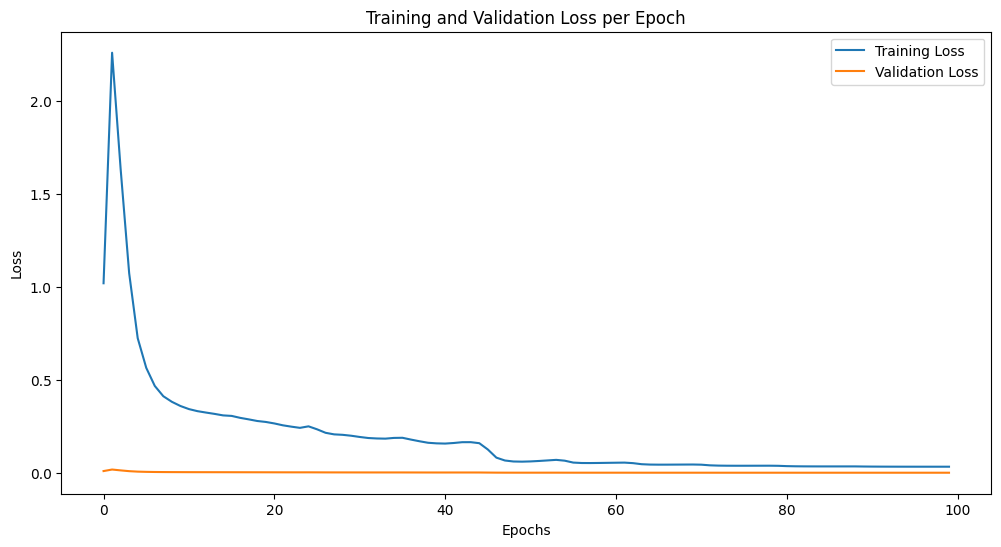

In [ ]:
import matplotlib.pyplot as plt



# Grafico di training e validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

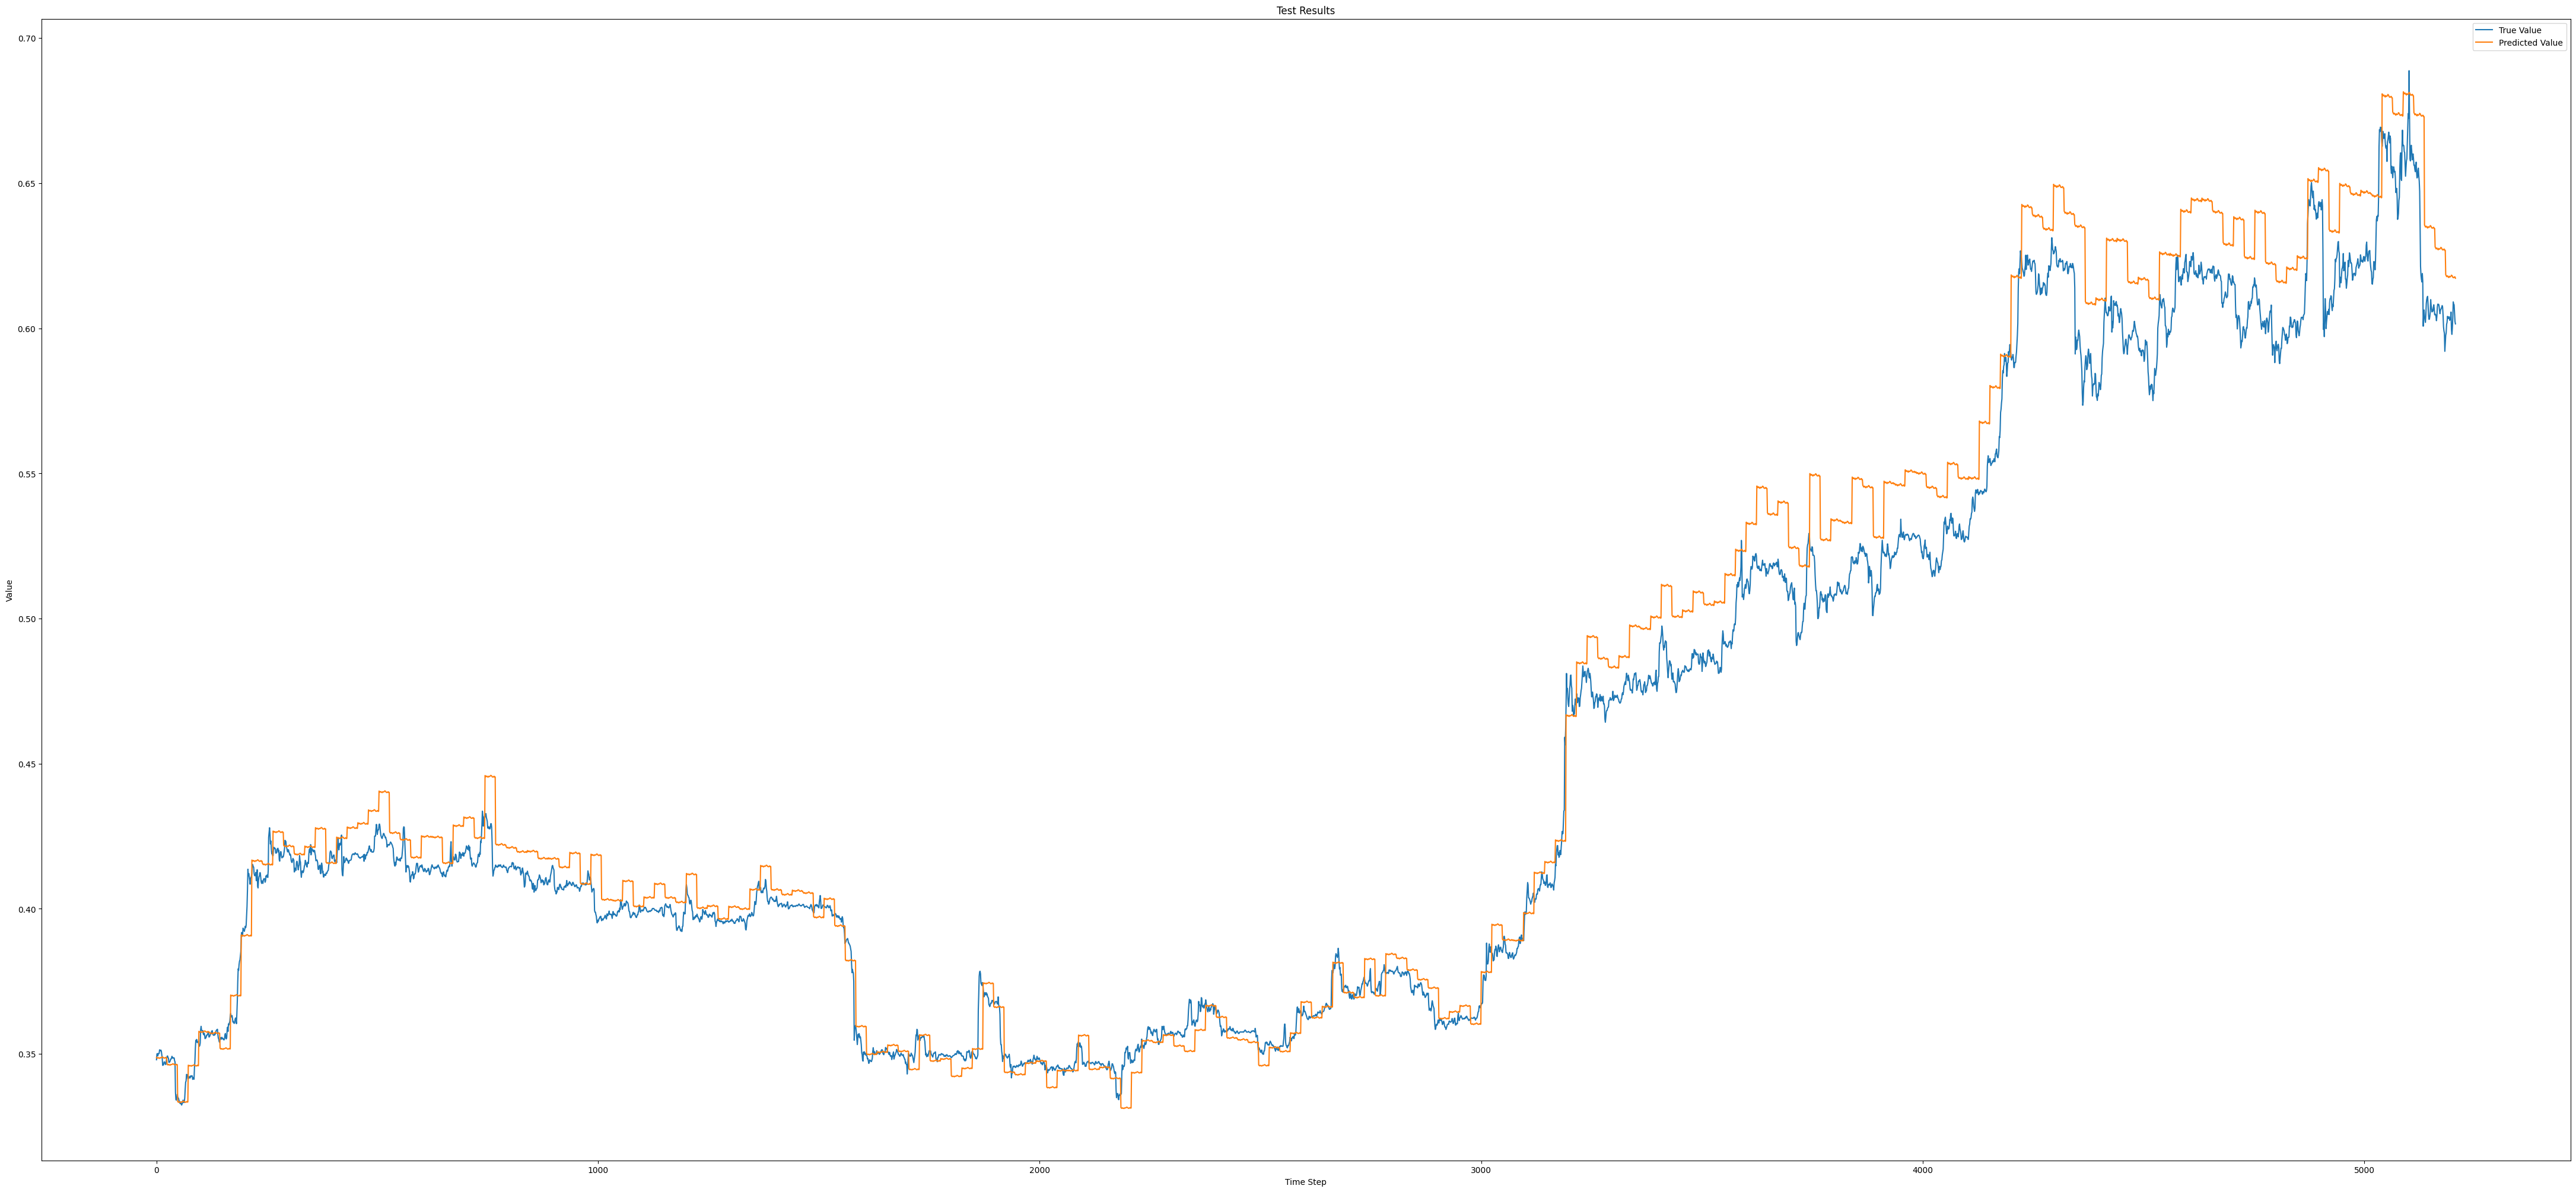

In [ ]:
plt.figure(figsize=(55, 25))
plt.plot(all_targetsTS_flat[:-1], label='True Value')
plt.plot(all_predictionsTS_flat[:-1], label='Predicted Value')


plt.title('Test Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


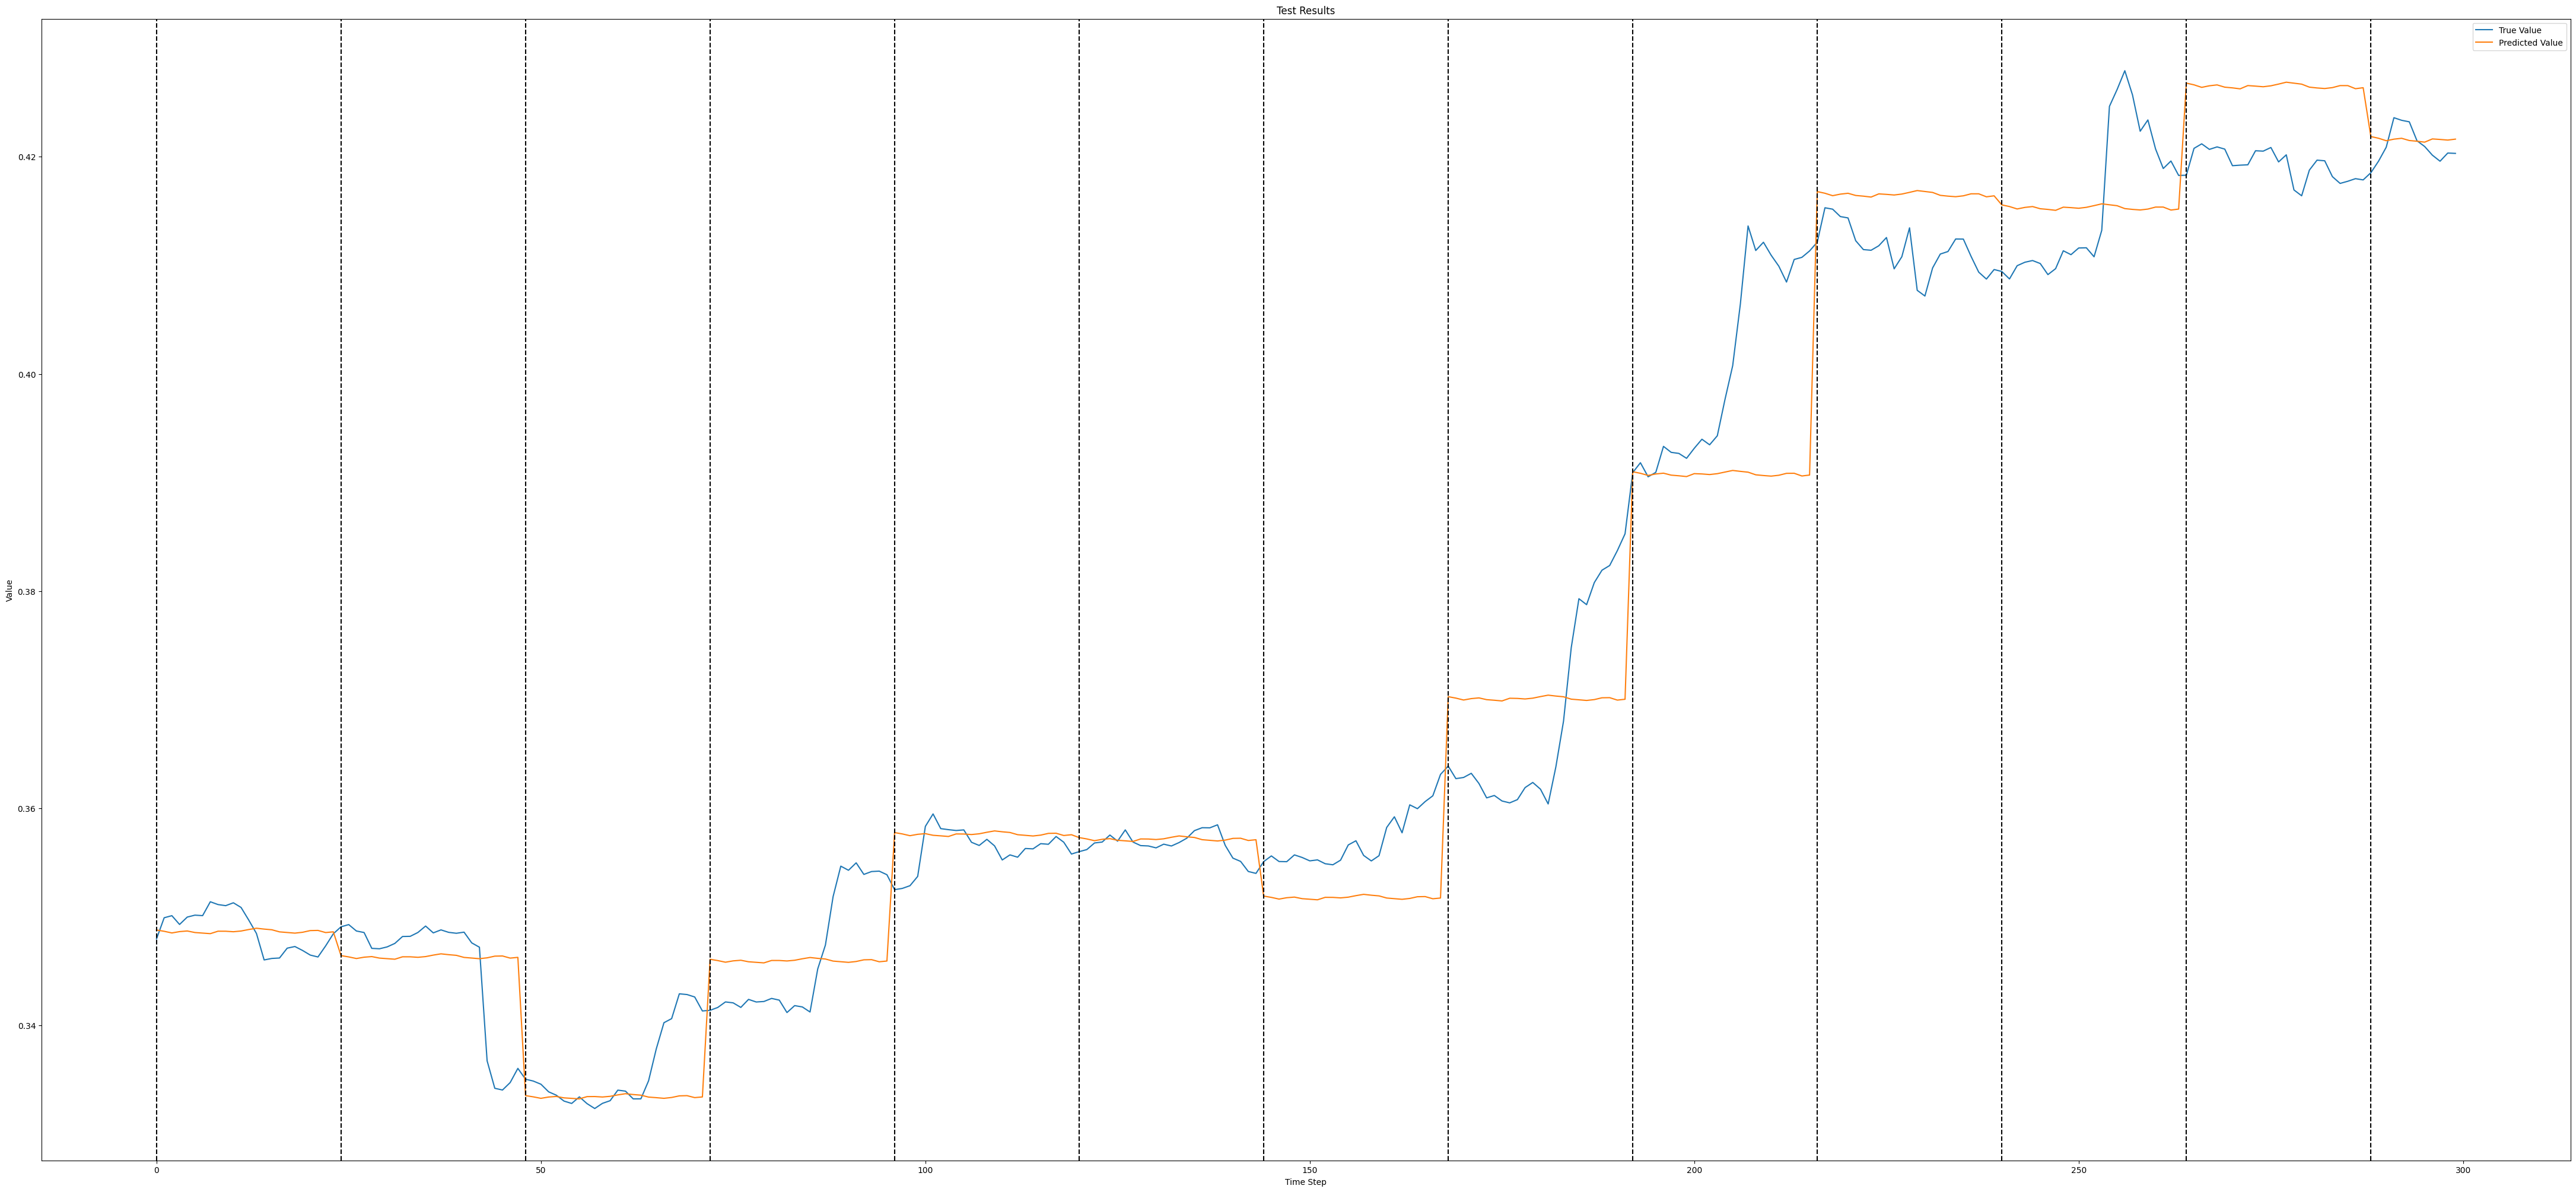

In [ ]:
plt.figure(figsize=(55, 25))
plt.plot(all_targetsTS_flat[:300], label='True Value')
plt.plot(all_predictionsTS_flat[:300], label='Predicted Value')
for i in range(0, 300, config['model']['NstepsAhead']):
    plt.axvline(x=i, color='k', linestyle='--')

plt.title('Test Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


Mean MSE over dataset: 0.00023499290908857246


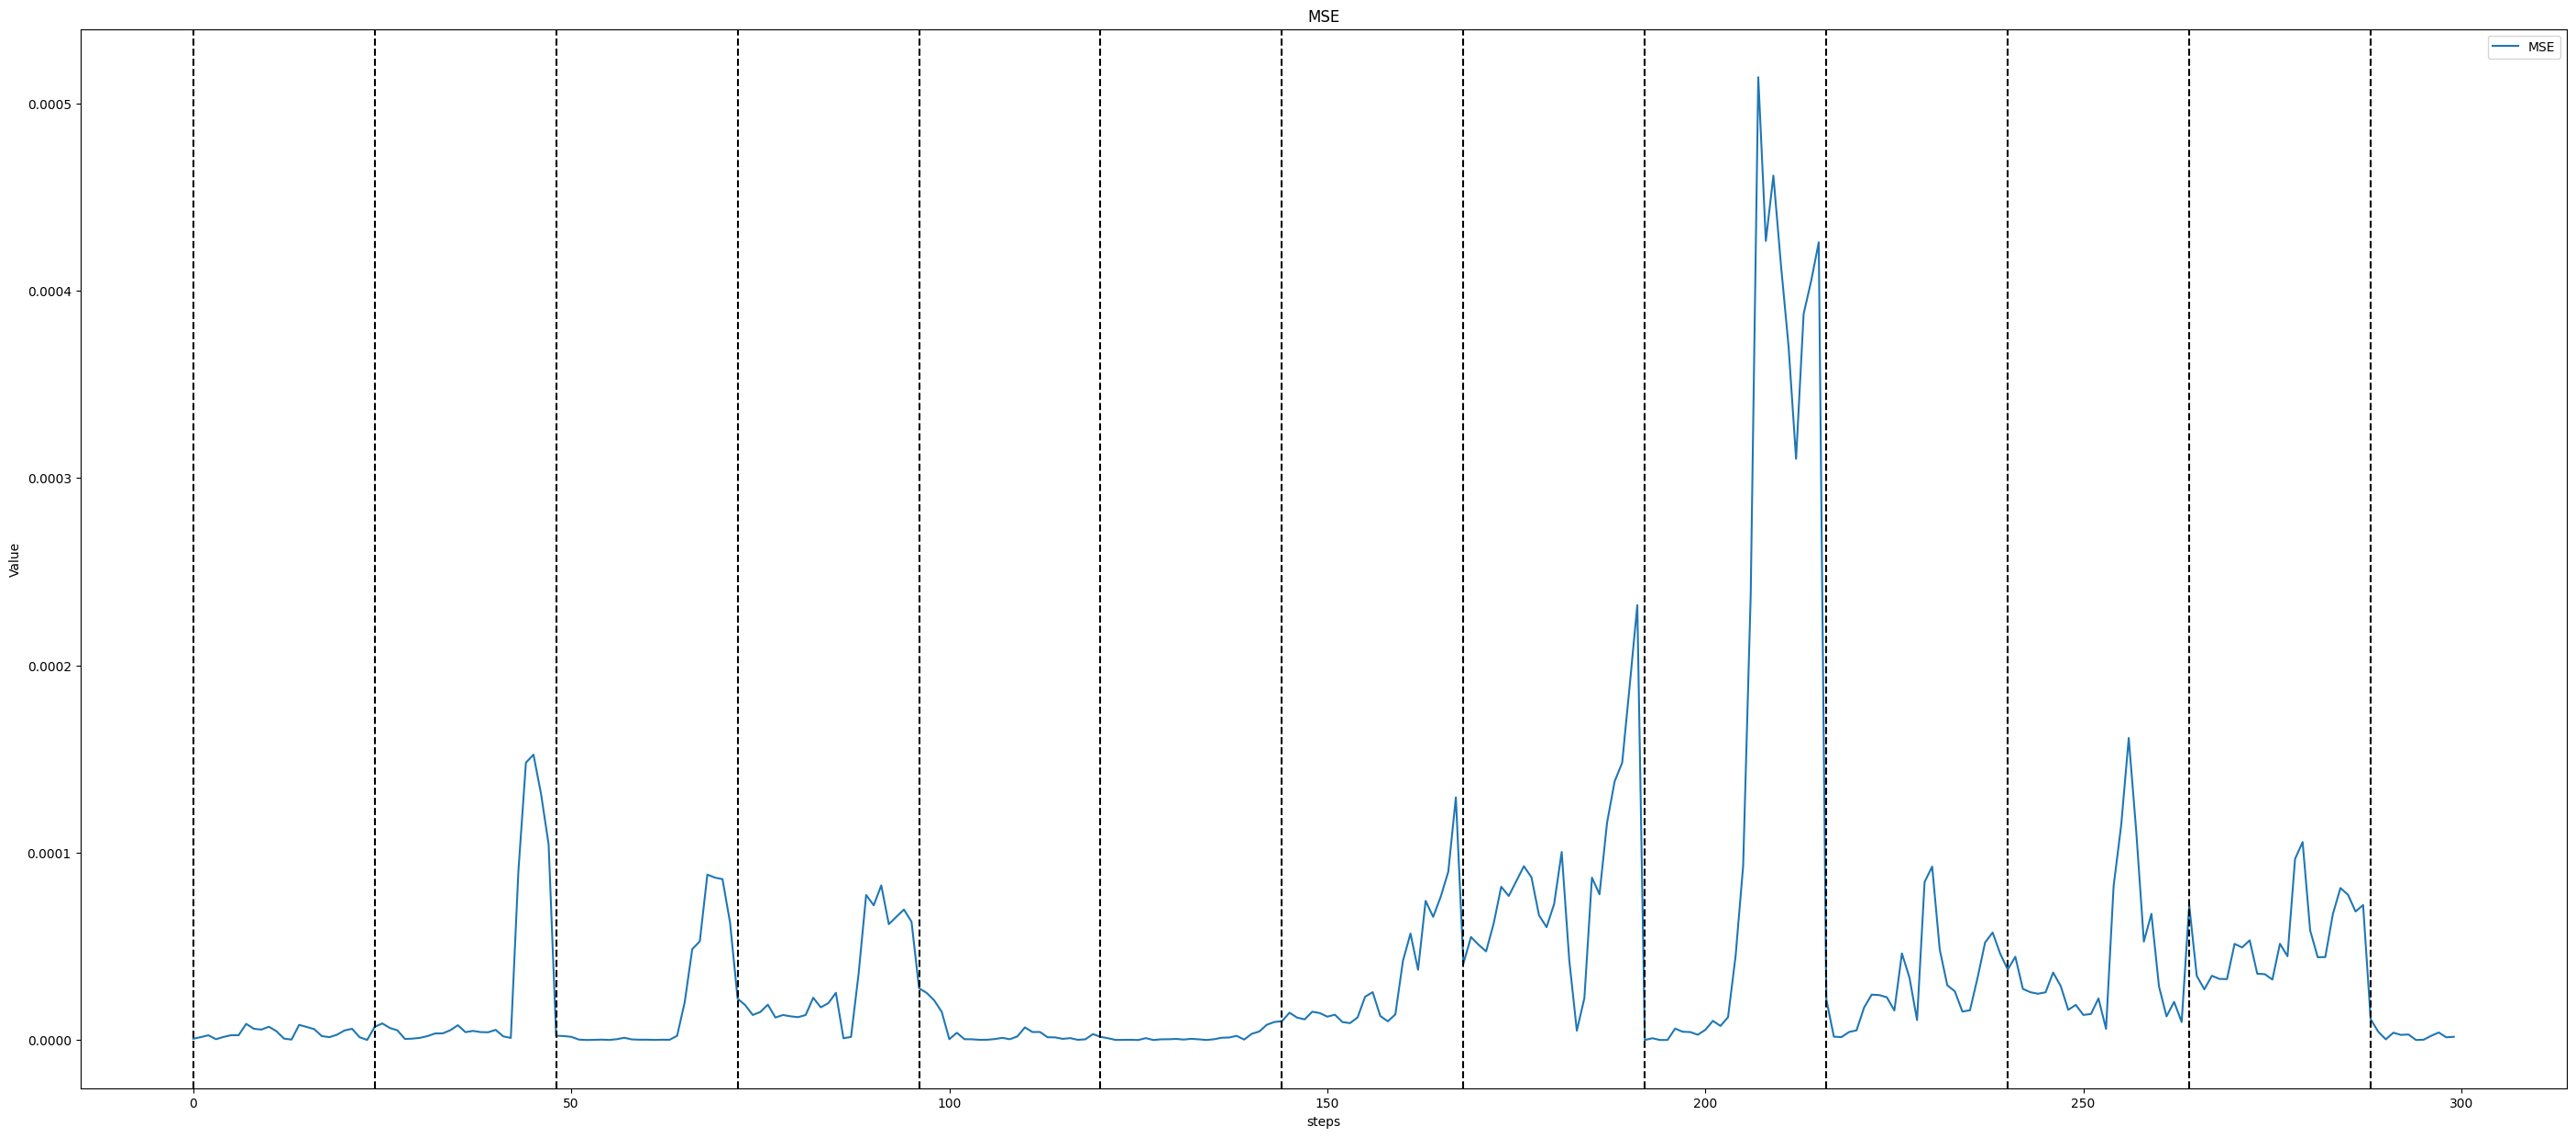

In [ ]:
# grafico andamento del mse elemento per elemento di tutto il training set

dfWresult = pd.DataFrame()


dfWresult["Y_true"] = all_targetsTS_flat
dfWresult["Y_pred"] = all_predictionsTS_flat




for i in range(len(dfWresult)):
   # Ensure the true and predicted values are passed as lists
   mse = mean_squared_error([dfWresult.at[i,"Y_true"]], [dfWresult.at[i,"Y_pred"]])
   dfWresult.at[i, "mse"] = mse

mse_mean = mean_squared_error(dfWresult["Y_true"], dfWresult["Y_pred"])

print(f"Mean MSE over dataset: {mse_mean}")
plt.figure(figsize=(35, 15))
plt.plot(dfWresult["mse"].iloc[:300], label='MSE')  # Corrected line
# Insert a vertical line every 24 steps
for i in range(0, 300, config['model']['NstepsAhead']):
    plt.axvline(x=i, color='k', linestyle='--')
plt.title('MSE')
plt.xlabel('steps')
plt.ylabel('Value')
plt.legend()
plt.show()

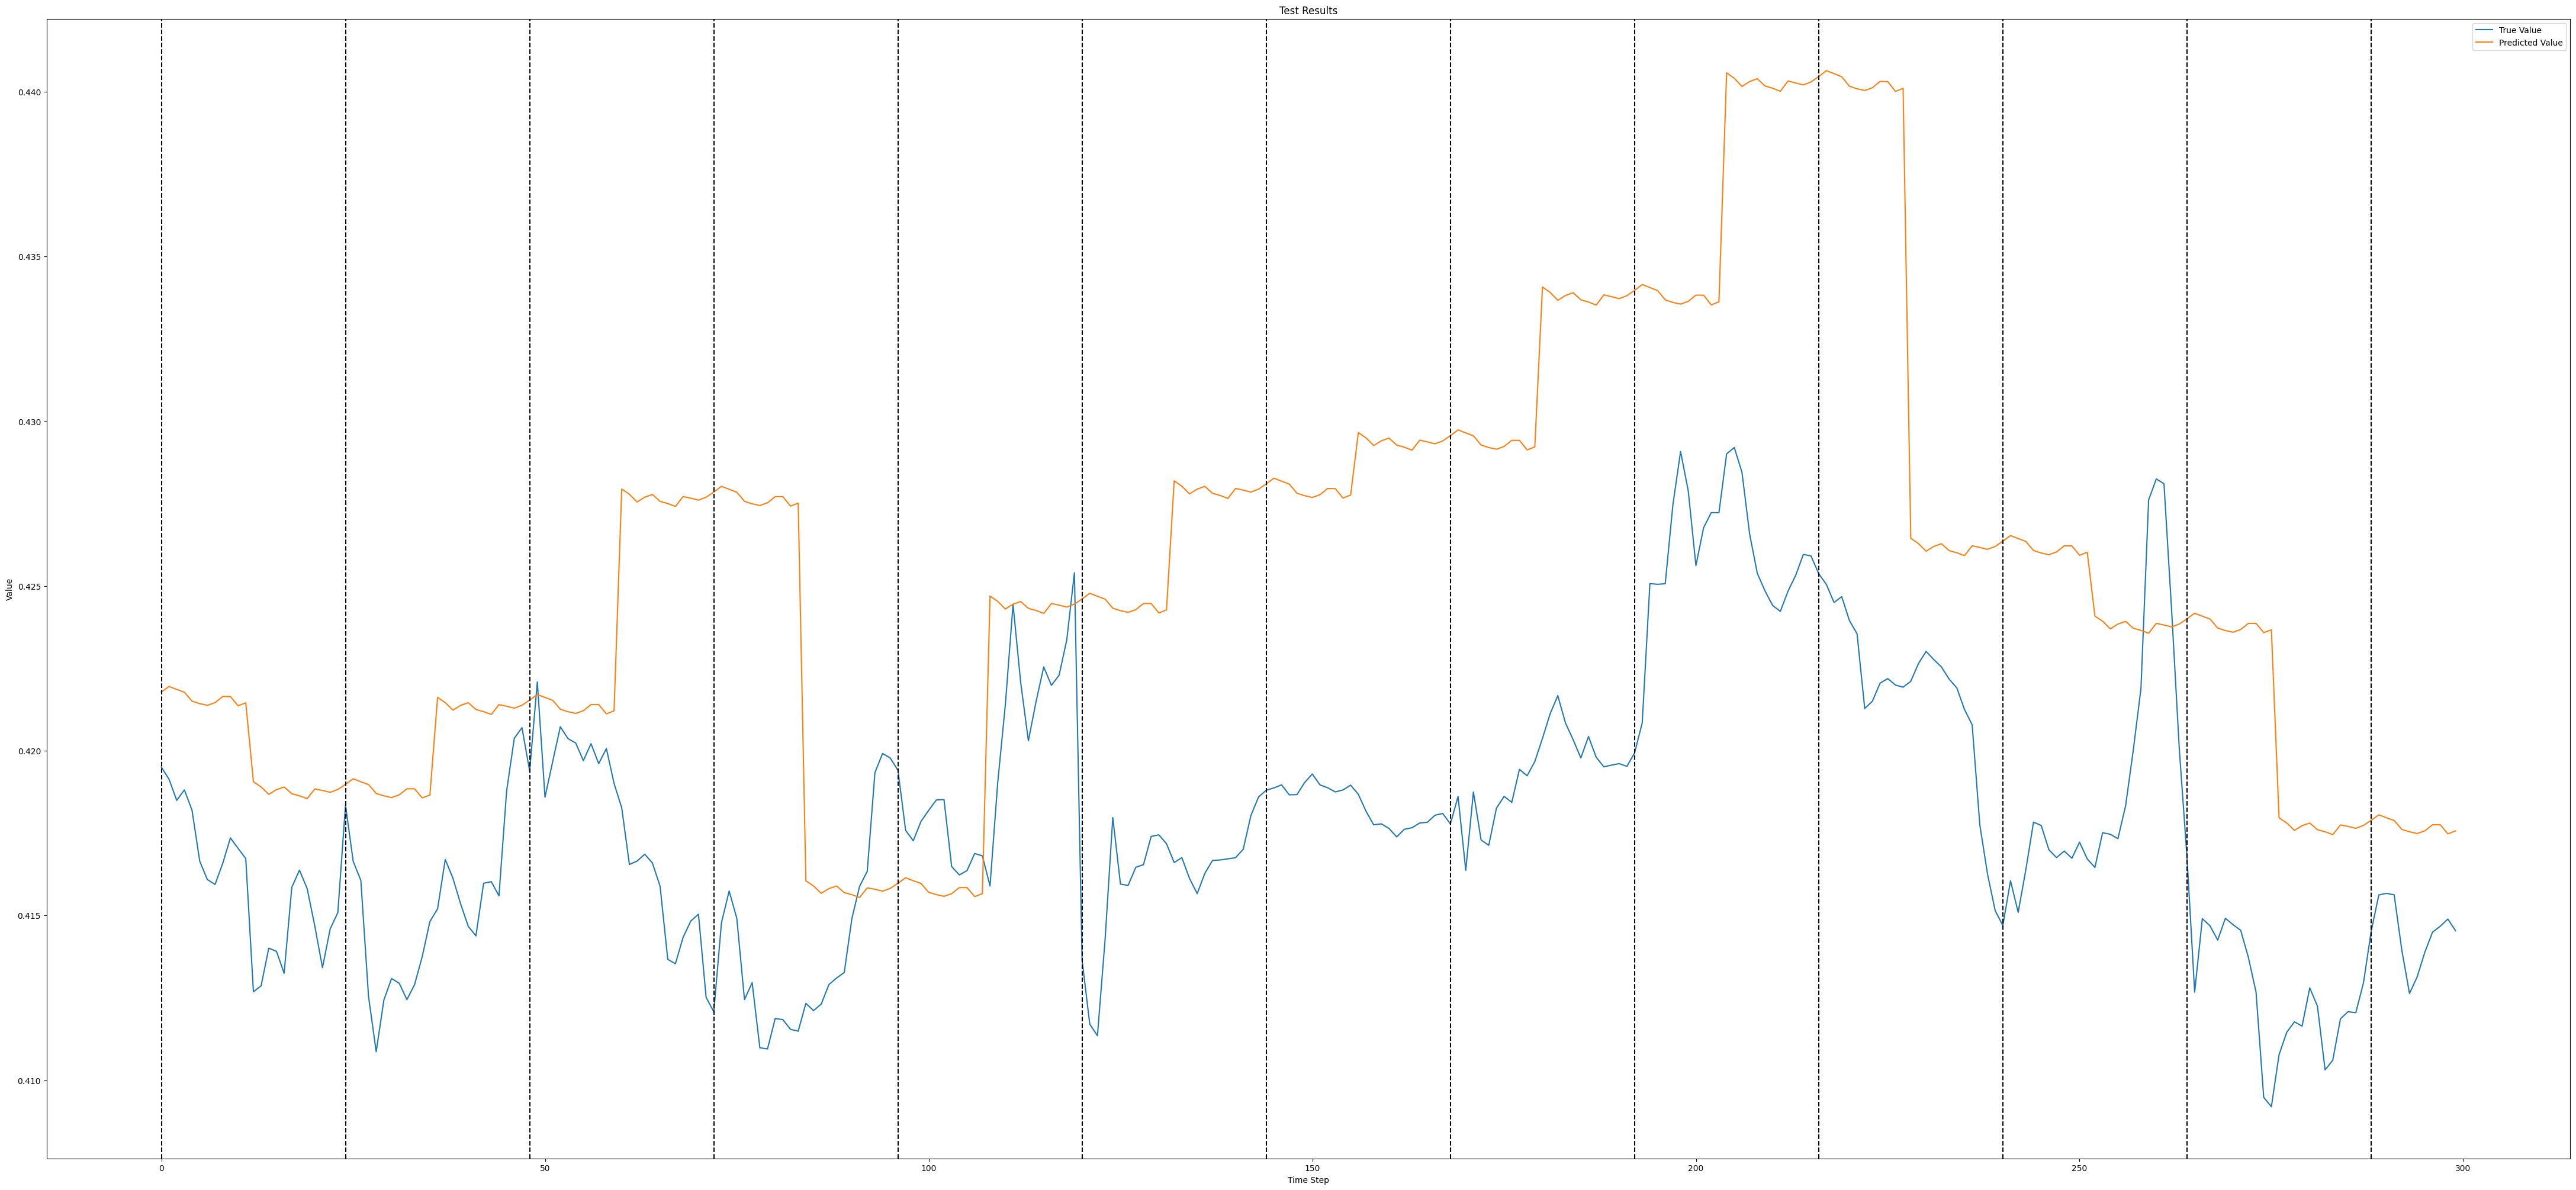

In [ ]:
plt.figure(figsize=(55, 25))
plt.plot(all_targetsTS_flat[300:600], label='True Value')
plt.plot(all_predictionsTS_flat[300:600], label='Predicted Value')
for i in range(0, 300, config['model']['NstepsAhead']):
    plt.axvline(x=i, color='k', linestyle='--')

plt.title('Test Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Mean MSE over dataset: 0.00023499290908857246


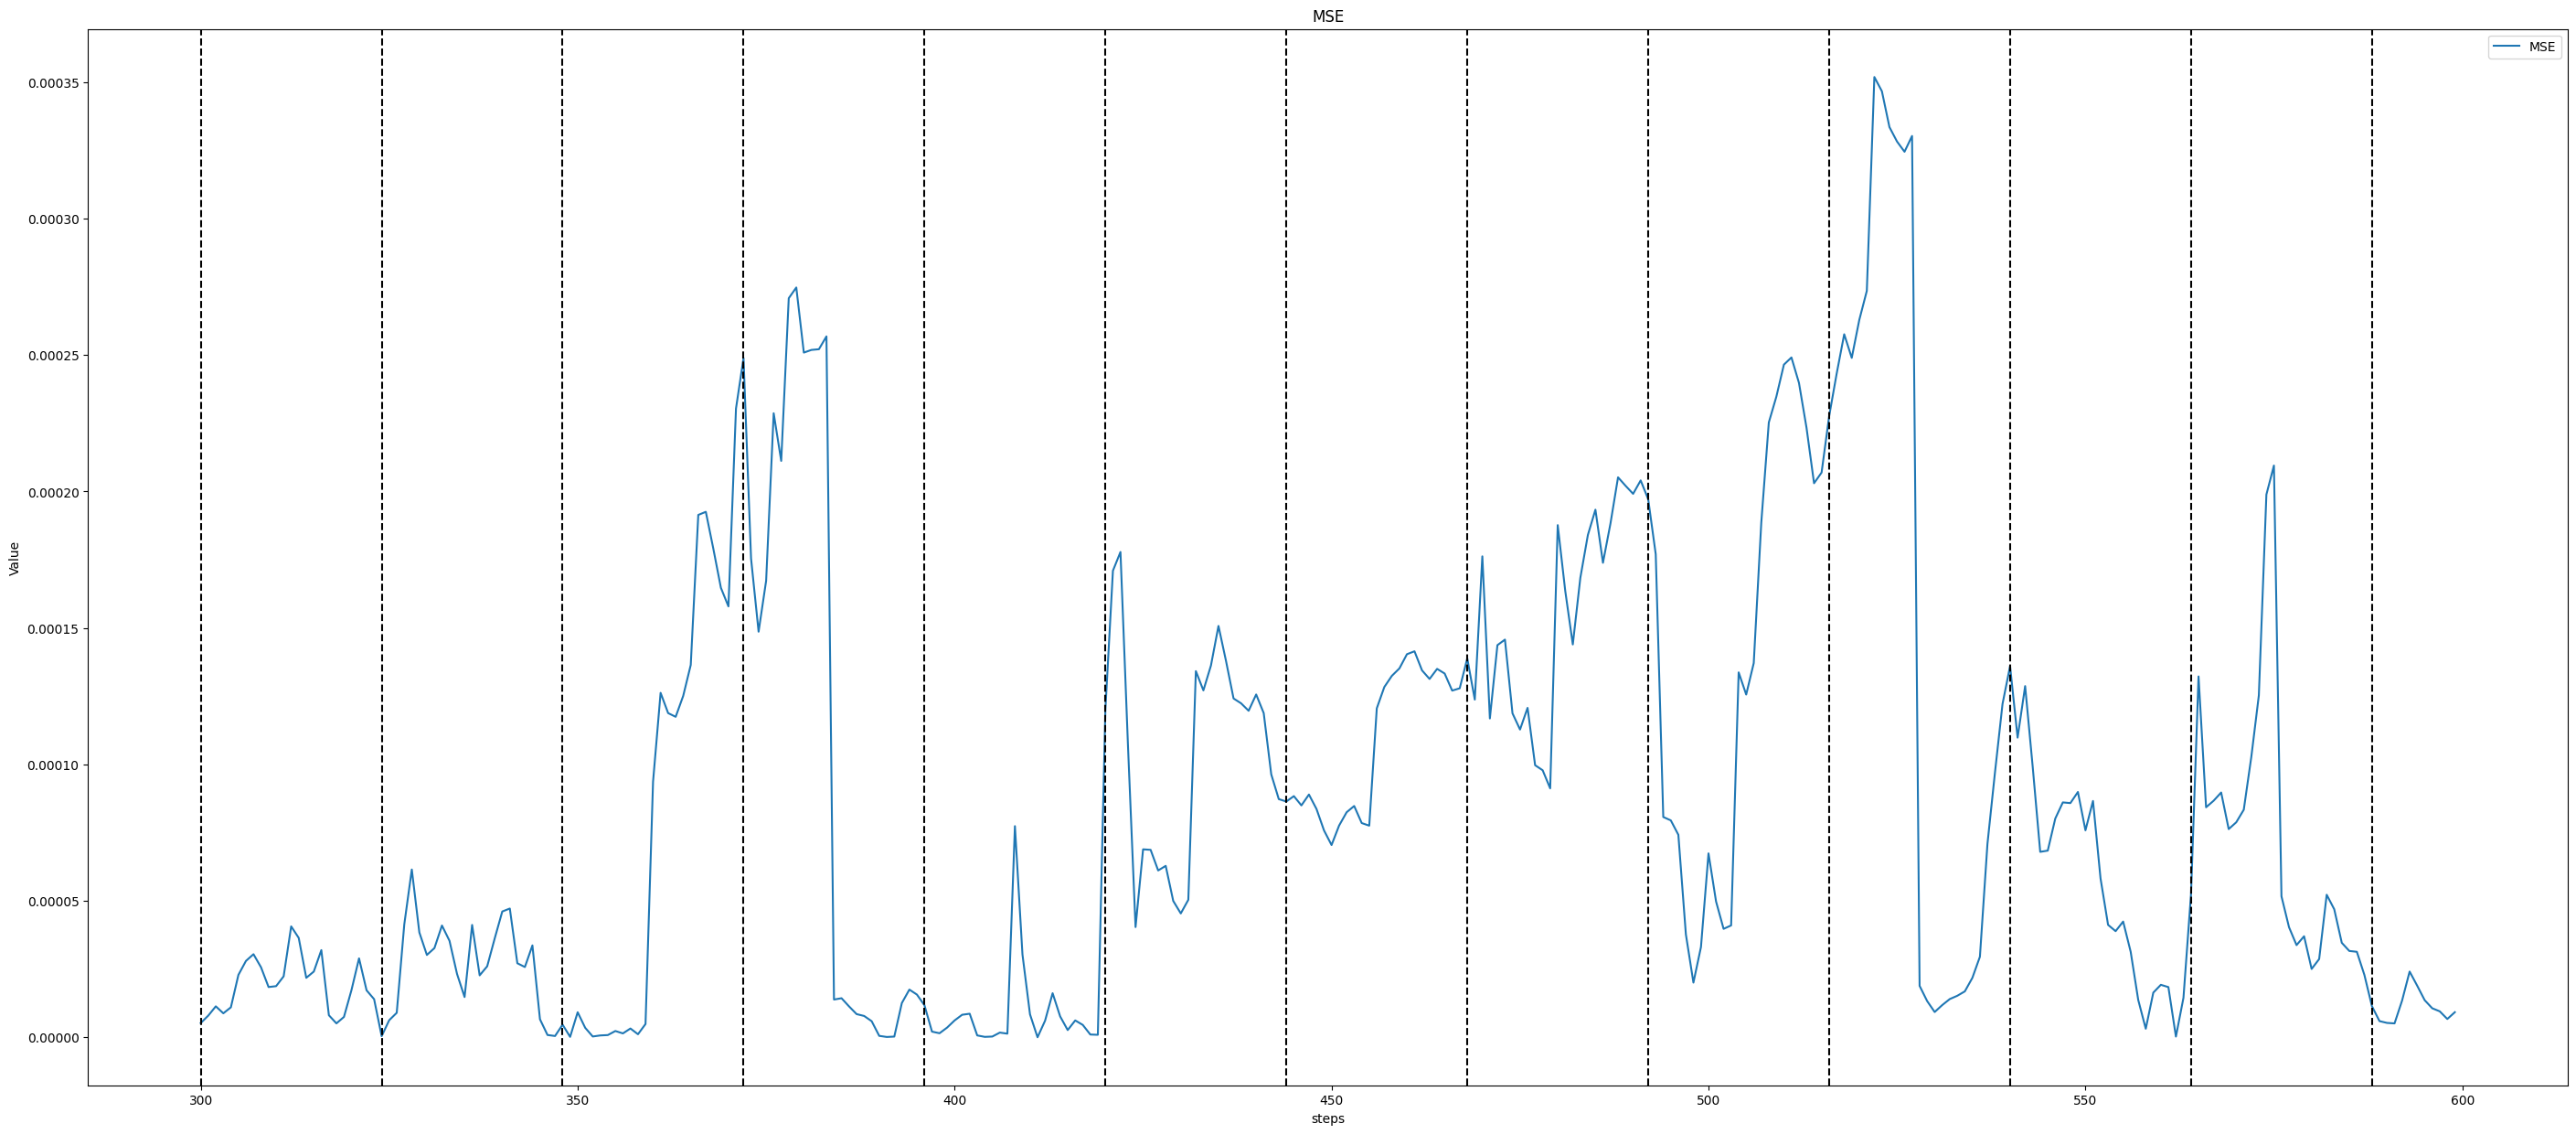

In [ ]:
# grafico andamento del mse elemento per elemento di tutto il training set

dfWresult = pd.DataFrame()


dfWresult["Y_true"] = all_targetsTS_flat
dfWresult["Y_pred"] = all_predictionsTS_flat




for i in range(len(dfWresult)):
   # Ensure the true and predicted values are passed as lists
   mse = mean_squared_error([dfWresult.at[i,"Y_true"]], [dfWresult.at[i,"Y_pred"]])
   dfWresult.at[i, "mse"] = mse

mse_mean = mean_squared_error(dfWresult["Y_true"], dfWresult["Y_pred"])

print(f"Mean MSE over dataset: {mse_mean}")
plt.figure(figsize=(35, 15))
plt.plot(dfWresult["mse"].iloc[300:600], label='MSE')  # Corrected line
# Insert a vertical line every 24 steps
for i in range(300, 600, config['model']['NstepsAhead']):
    plt.axvline(x=i, color='k', linestyle='--')
plt.title('MSE')
plt.xlabel('steps')
plt.ylabel('Value')
plt.legend()
plt.show()

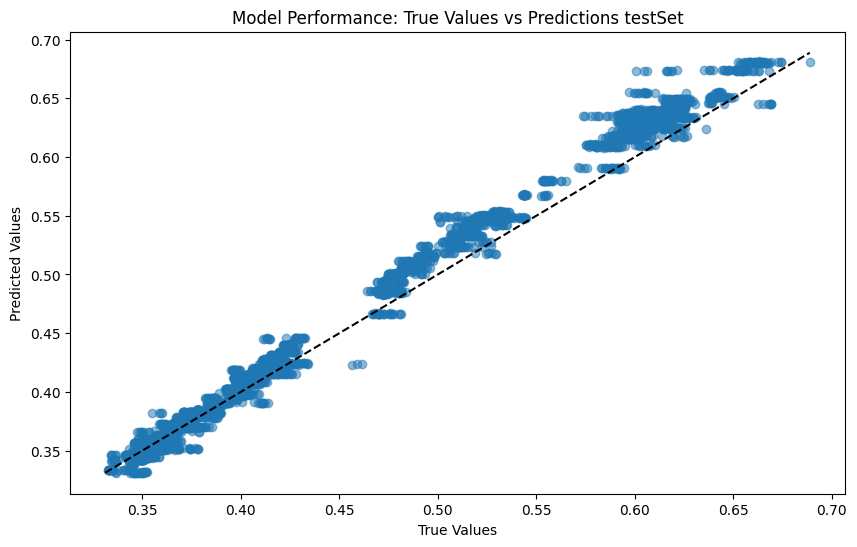

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy if it's not already

# Assuming y_true_flat and y_pred_flat are lists, convert them to NumPy arrays
y_true_flat_np = np.array(all_targetsTS_flat)
y_pred_flat_np = np.array(all_predictionsTS_flat)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true_flat_np, y_pred_flat_np, alpha=0.5)
plt.title('Model Performance: True Values vs Predictions testSet')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot the perfect prediction line
max_val = max(y_true_flat_np.max(), y_pred_flat_np.max())
min_val = min(y_true_flat_np.min(), y_pred_flat_np.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Assuming 'scaler' is the MinMaxScaler instance that was used to scale the dataset originally
# and 'dataSet' is your original DataFrame before normalization
# Load the scaler from the saved file (you should replace the file path with the location where you stored your scaler)



# Denormalize y_true
dummy_feature_count = dataSet.shape[1] - 1
dummy_array_true = np.zeros((y_true_flat_np.shape[0], dummy_feature_count))
input_array_true = np.column_stack((dummy_array_true, y_true_flat_np))
denormalized_y_true = scaler.inverse_transform(input_array_true)[:, -1]

# Denormalize y_pred
dummy_array_pred = np.zeros((y_pred_flat_np.shape[0], dummy_feature_count))
input_array_pred = np.column_stack((dummy_array_pred, y_pred_flat_np))
denormalized_y_pred = scaler.inverse_transform(input_array_pred)[:, -1]

# Create DataFrame for denormalized values
denormalizeDf = pd.DataFrame()
denormalizeDf["Y_true"] = denormalized_y_true
denormalizeDf["Y_pred"] = denormalized_y_pred

# Calculate MSE for each pair of true and predicted values
for i in range(len(denormalizeDf)):
   mse = mean_squared_error([denormalizeDf.at[i,"Y_true"]], [denormalizeDf.at[i,"Y_pred"]])
   denormalizeDf.at[i, "mse"] = mse

# Calculate the mean MSE
mse_mean = mean_squared_error(denormalizeDf["Y_true"], denormalizeDf["Y_pred"])

# Display the first few rows of the DataFrame
denormalizeDf.head()


,Y_true,Y_pred,mse
0,3.539443e+09,3.565603e+09,6.843545e+14
1,3.601332e+09,3.561796e+09,1.563141e+15
2,3.607417e+09,3.556943e+09,2.547567e+15
3,3.581755e+09,3.560875e+09,4.359478e+14
4,3.603292e+09,3.562705e+09,1.647279e+15


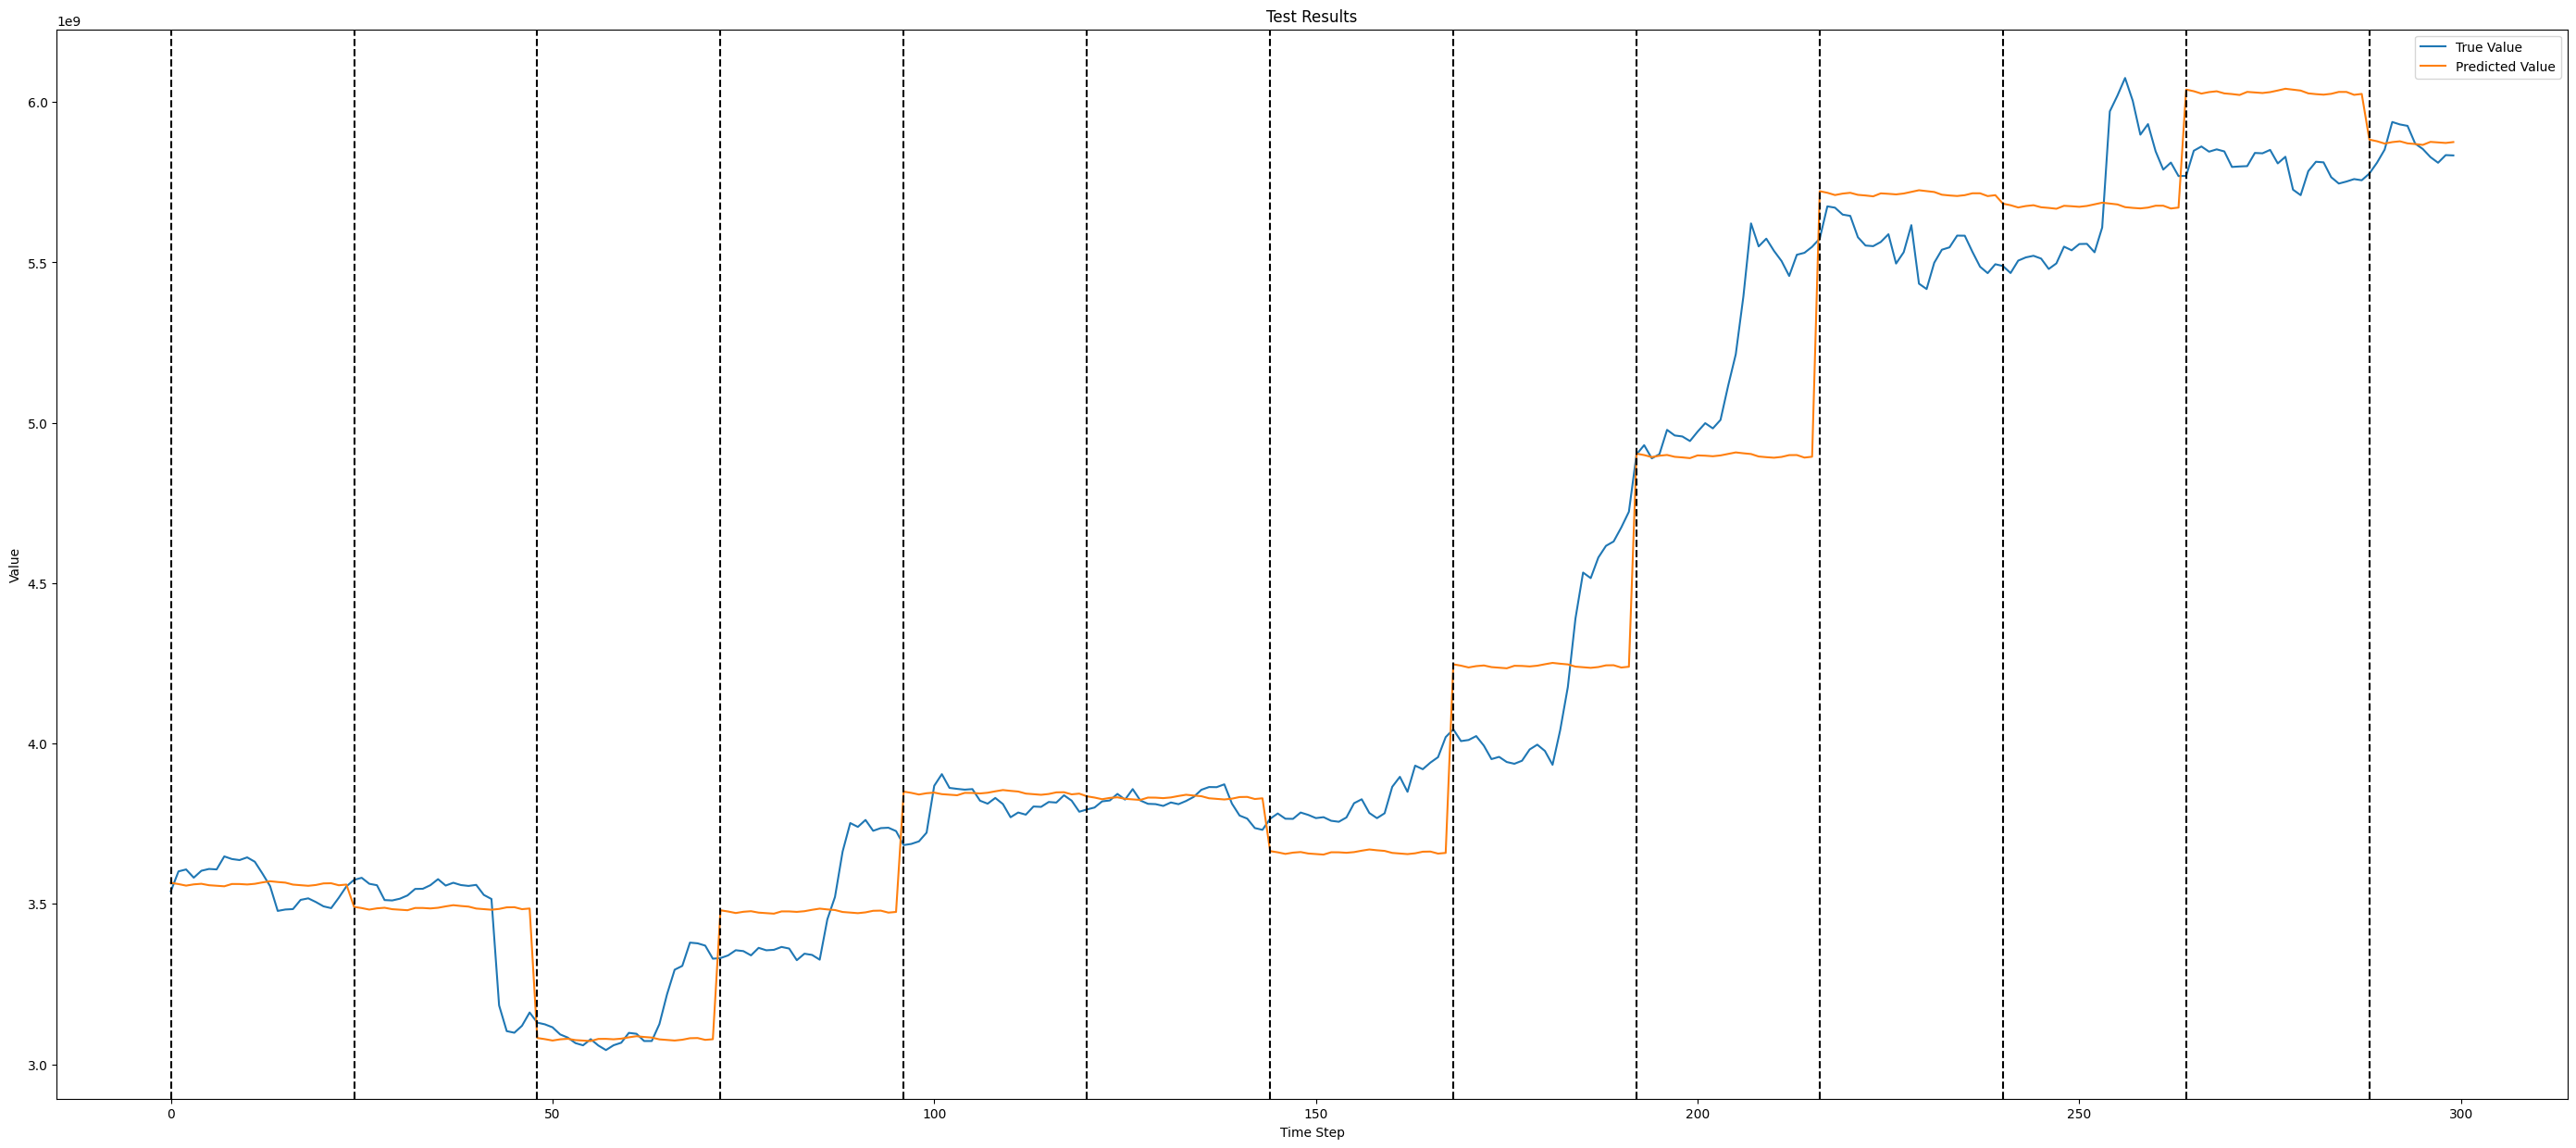

In [ ]:
plt.figure(figsize=(35, 15))
plt.plot(denormalized_y_true[:300], label='True Value')
plt.plot(denormalized_y_pred[:300], label='Predicted Value')
for i in range(0, 300, config['model']['NstepsAhead']):
    plt.axvline(x=i, color='k', linestyle='--')

plt.title('Test Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()